In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np

chars = ['Relevancy', 'Correctness', 'Completeness', 'Informativeness', 'Integration', 'Cohesion', 'Coherence', 'Readability', 'Conciseness']

FOLD_NO = 3

def read_json(input_path):
    """
    Reads the ``json`` file of the given ``input_path``.

    :param input_path: Path to the json file
    :return: A loaded json object.
    """
    with open(input_path, encoding="utf-8") as f:
        json_data = json.load(f)

    return json_data

def word_counter_calculator(column):
    N_wc_lower = []
    N_wc_upper = []
    for col in column:
        wc = len(col.strip().split())
        N_wc_upper.append(1 if wc > 200 else 0)
        N_wc_lower.append(1 if wc < 50 else 0)
    return {"wc_upper": N_wc_upper, "wc_lower": N_wc_lower}

def evaluation_report(result_list, model, setting, fold_prefix='gpt-4-eval-'):
    print("MODEL:", model)
    print("SETTING:", setting)
    results_dict = {
        "word-count":[],
        "WC>200": [],
        "WC<50": [],
        "50<=WC<150": [],
        "150<=WC<=220": [],
        "220<=WC<=250": [],
        "150<=WC<=250": [],
        "WC>250":[],
        "paper-structure-score": [],
        
    }

    scores = {
        "Relevancy":0, "Correctness":0, "Completeness":0, 
        "Informativeness": 0, "Integration": 0, "Cohesion":0,
        "Coherence":0, "Readability":0, "Conciseness": 0
    }
    
    for inf in result_list:
        results_dict['WC>200'].append(inf['basic-eval']['word-count']['WC>200'])
        results_dict['WC<50'].append(inf['basic-eval']['word-count']['WC<50'])
        results_dict['50<=WC<150'].append(inf['basic-eval']['word-count']['50<=WC<150'])
        results_dict['150<=WC<=220'].append(inf['basic-eval']['word-count']['150<=WC<=220'])
        results_dict['220<=WC<=250'].append(inf['basic-eval']['word-count']['220<=WC<=250'])
        results_dict['150<=WC<=250'].append(inf['basic-eval']['word-count']['150<=WC<=250'])
        results_dict['WC>250'].append(inf['basic-eval']['word-count']['WC>250'])
        
        results_dict['word-count'].append(inf['basic-eval']['word-count']['count'])
        results_dict['paper-structure-score'].append(inf['basic-eval']['paper-structure'])

        avg_scores = {
            "Relevancy":0, "Correctness":0, "Completeness":0, 
            "Informativeness": 0, "Integration": 0, "Cohesion":0,
            "Coherence":0, "Readability":0, "Conciseness": 0
        }
        for keys in [f'{fold_prefix}{setting}-'+str(idx+1) for idx in range(FOLD_NO)]:
            if keys == 'gpt-4-eval-s1-1' and model=='vanila':
                items = inf[keys].items()
            else:
                items = inf[keys]['eval-result'].items()
            for key, score in items:
                if score['rating'] == '':
                    avg_scores[key] += 5
                else:
                    avg_scores[key] += int(score['rating'])
        for key, score in avg_scores.items():
            avg_scores[key] = score/FOLD_NO

        for key, score in avg_scores.items():
            scores[key] += score

    for metric, score in scores.items():
        scores[metric] /= len(result_list)
    
    avg = sum(results_dict['WC>200'])/len(results_dict['WC>200'])
    print("averaged WC>200:", avg)
    
    avg_wc = sum(results_dict['word-count'])/len(results_dict['word-count'])
    print("averaged word counts:", avg_wc)
    
    avg = sum(results_dict['150<=WC<=250'])/len(results_dict['150<=WC<=250'])
    print("averaged 150<=WC<=250:", avg)
    
    avg  = sum(results_dict['WC<50'])/len(results_dict['WC<50'])
    print("averaged WC<50:", avg)
    
    avg  = sum(results_dict['50<=WC<150'])/len(results_dict['50<=WC<150'])
    print("averaged 50<=WC<150:", avg)
    
    avg = sum(results_dict['150<=WC<=220'])/len(results_dict['150<=WC<=220'])
    print("averaged 150<=WC<=220:", avg)
    
    avg = sum(results_dict['220<=WC<=250'])/len(results_dict['220<=WC<=250'])
    print("averaged 220<=WC<=250:", avg)
    
    avg = sum(results_dict['WC>250'])/len(results_dict['WC>250'])
    print("averaged WC>250:", avg)

    print("averaged paper-structure:", sum(results_dict['paper-structure-score'])/len(results_dict['paper-structure-score']))
    
    return scores, results_dict

def get_avg_scores_per_fold(result_list, setting):
    avg_scores = {
        "Relevancy":0, "Correctness":0, "Completeness":0, 
        "Informativeness": 0, "Integration": 0, "Cohesion":0,
        "Coherence":0, "Readability":0, "Conciseness": 0
    }
    for inf in result_list:
        
        try:
            items = inf[setting]['eval-result'].items()
        except:
            items = inf[setting].items()
        for key, score in items:
            # print (key, score['rating'])
            if score['rating'] == '':
                avg_scores[key] += 5
            else:
                avg_scores[key] += int(score['rating'])
    for metric, score in avg_scores.items():
        avg_scores[metric] /= len(result_list)

    return avg_scores

def build_setting_per_fold_matrix(result_list, setting, chars, fold_prefix='gpt-4-eval-'):
    setting_scores = []
    for setting_fold in [f'{fold_prefix}{setting}-'+str(idx+1) for idx in range(FOLD_NO)]:
        avg = get_avg_scores_per_fold(result_list, setting_fold)
        fold_scores = []
        for char in chars:
            fold_scores.append(avg[char])
        setting_scores.append(fold_scores)
    return setting_scores

def plot_s1_vs_s2(setting1_scores, setting2_scores, model, chars):
    # Convert to numpy arrays for easier manipulation
    setting1_scores = np.array(setting1_scores)
    setting2_scores = np.array(setting2_scores)

    ig, ax = plt.subplots(figsize=(12, 4))

    # Scatter plot for Setting 1
    for i, char in enumerate(chars):
        ax.scatter(np.full_like(setting1_scores[:, i], i*2 - 0.2), setting1_scores[:, i], color='blue', alpha=0.7)

    for i, char in enumerate(chars):
        ax.scatter(np.full_like(np.mean(setting1_scores[:, i]), i*2 - 0.2), np.mean(setting1_scores[:, i]), color='green', alpha=0.7)


    # Scatter plot for Setting 2
    for i, char in enumerate(chars):
        ax.scatter(np.full_like(setting2_scores[:, i], i*2 + 0.2), setting2_scores[:, i],  color='red', alpha=0.7)

    for i, char in enumerate(chars):
        ax.scatter(np.full_like(np.mean(setting2_scores[:, i]), i*2 + 0.2), np.mean(setting2_scores[:, i]), color='black', alpha=0.7)


    # Create custom legend handles
    blue_dot = plt.Line2D([0], [0], marker='o', color='blue', linestyle='None', markersize=5)
    red_dot = plt.Line2D([0], [0], marker='o', color='red', linestyle='None', markersize=5)
    green_dot = plt.Line2D([0], [0], marker='o', color='green', linestyle='None', markersize=5)
    black_dot = plt.Line2D([0], [0], marker='o', color='black', linestyle='None', markersize=5)

    # Customizing the plot
    ax.set_xticks(np.arange(len(chars)) * 2)
    ax.set_xticklabels(chars)
    ax.set_xlabel('Characteristics')
    ax.set_ylabel('Scores')
    # ax.set_title('Scatter Plot of Scores by Characteristics and Evaluation Settings')

    legend_labels = ['Setting-1', 'Setting-2', "Setting-1 Avg. Scores", "Setting-2 Avg. Scores"]

    # Add legend
    ax.legend(handles=[blue_dot, red_dot, green_dot, black_dot], labels=legend_labels, loc='lower right')

    plt.tight_layout()

    plt.savefig(f"images/{model}-s1-vs-s2.jpg")
    plt.show()

def plot_s1_vs_s2_vs_prolofic(setting1_scores, setting2_scores, prolofic_scores, model, chars):
    # Convert to numpy arrays for easier manipulation
    setting1_scores = np.array(setting1_scores)
    setting2_scores = np.array(setting2_scores)
    prolofic_scores =  np.array(prolofic_scores)

    ig, ax = plt.subplots(figsize=(12, 4))

    # Scatter plot for Setting 1
    # for i, char in enumerate(chars):
    #     ax.scatter(np.full_like(setting1_scores[:, i], i*2 - 0.2), setting1_scores[:, i], color='blue', alpha=0.7)

    for i, char in enumerate(chars):
        ax.scatter(np.full_like(np.mean(setting1_scores[:, i]), i*2 - 0.2), np.mean(setting1_scores[:, i]), color='blue', alpha=0.7)


    # Scatter plot for Setting 2
    # for i, char in enumerate(chars):
    #     ax.scatter(np.full_like(setting2_scores[:, i], i*2 + 0.2), setting2_scores[:, i],  color='red', alpha=0.7)

    for i, char in enumerate(chars):
        ax.scatter(np.full_like(np.mean(setting2_scores[:, i]), i*2 + 0.2), np.mean(setting2_scores[:, i]), color='black', alpha=0.7)
    
    # Scatter plot for prolofic_scores 2
    for i, char in enumerate(chars):
        ax.scatter(np.full_like(np.mean(prolofic_scores[:, i]), i*2 + 0.2), np.mean(prolofic_scores[:, i]), color='red', alpha=0.7)

    # Create custom legend handles
    blue_dot = plt.Line2D([0], [0], marker='o', color='blue', linestyle='None', markersize=5)
    red_dot = plt.Line2D([0], [0], marker='o', color='red', linestyle='None', markersize=5)
    green_dot = plt.Line2D([0], [0], marker='o', color='green', linestyle='None', markersize=5)
    black_dot = plt.Line2D([0], [0], marker='o', color='black', linestyle='None', markersize=5)

    # Customizing the plot
    ax.set_xticks(np.arange(len(chars)) * 2)
    ax.set_xticklabels(chars)
    ax.set_xlabel('Characteristics')
    ax.set_ylabel('Scores')
    # ax.set_title('Scatter Plot of Scores by Characteristics and Evaluation Settings')

    legend_labels = ["Setting-1 Avg. Scores", "Setting-2 Avg. Scores", "Prolofic-Human Avg. Scores" ]

    # Add legend
    ax.legend(handles=[blue_dot, black_dot, red_dot], labels=legend_labels, loc='lower right')

    plt.tight_layout()

    plt.savefig(f"images/{model}-s1-vs-s2-vs-prolofic.jpg")
    plt.show()

# Prolofic Human Evaluation comparison

In [3]:
import pandas as pd
from scripts.dataset import format_context
from scripts.utils import paper_structure_score, word_count_score
from scripts.configs import BaseConfig
from scripts import io

args = BaseConfig().get_args()

reward_vocab = io.read_text(args.reward_vocab).split("\n")
reward_vocab = [vocab.lower() for vocab in reward_vocab]
    
mdf = pd.read_csv("dataset/split/Mistral-7B/ProlificHuman/prolific_mistral_methodological.csv")
pdf = pd.read_csv("dataset/split/Mistral-7B/ProlificHuman/prolific_mistral_paper-wise.csv")
tdf = pd.read_csv("dataset/split/Mistral-7B/ProlificHuman/prolific_mistral_thematic.csv")

In [4]:
prolofic_dataset = []


def format_context(row):
    context = ""
    for i in range(5):
        title = row[f'paper_{i+1}_title'] 
        abstract = row[f'paper_{i+1}_abstract'] 
        context += f'{i+1}. ' + ' '.join(title.replace('\n', ' ').split()) + '\n' + ' '.join(abstract.replace('\n', ' ').split()) + '\n\n'
    return context 

synthesis_types = ["methodological", "paperwise", "thematic"]

ph_dfs = [mdf, pdf, tdf]
for idx, synthesis_type in enumerate(synthesis_types):
    
    for index, row in ph_dfs[idx].iterrows(): 
        context = format_context(row)
        research_problem = row['research_problem']
        eval_results = {}
        for person in ["P1", "P2", "P3"]:
            eval_result = {}
            for char in chars:
                char_lower = char.lower()
                rating = row[f'{char_lower}_rating_{person}']
                rationale = row[f'{char_lower}_comment_{person}']
                eval_result[char] = {"rating":rating, "rationale":rationale}
            eval_results[person] = eval_result


        prolofic_dataset.append({
            "synthesis": synthesis_type, 
            "split": 'test-prolific', 
            "sample_id":row['sample_id'], 
            "prompt": "", 
            "inference": row['synthesis_text'],
            "P-1": {"eval-result": eval_results['P1']},
            "P-2": {"eval-result": eval_results['P2']},
            "P-3": {"eval-result": eval_results['P3']},
            "basic-eval": {
                    "paper-structure": paper_structure_score(row['synthesis_text'], reward_vocab), 
                    "word-count": word_count_score(row['synthesis_text'])
            }
        })

len(prolofic_dataset)

30

MODEL: prolofic_dataset
SETTING: P
averaged WC>200: 0.4666666666666667
averaged word counts: 199.73333333333332
averaged 150<=WC<=250: 0.4
averaged WC<50: 0.0
averaged 50<=WC<150: 0.36666666666666664
averaged 150<=WC<=220: 0.16666666666666666
averaged 220<=WC<=250: 0.23333333333333334
averaged WC>250: 0.23333333333333334
averaged paper-structure: 0.2
{
    "Relevancy": 4.066666666666667,
    "Correctness": 3.877777777777778,
    "Completeness": 3.4999999999999996,
    "Informativeness": 3.7222222222222223,
    "Integration": 3.5999999999999996,
    "Cohesion": 3.7,
    "Coherence": 3.755555555555555,
    "Readability": 4.088888888888888,
    "Conciseness": 3.766666666666666
}
--------------------------------------------------
MODEL: vanila
SETTING: s1
averaged WC>200: 0.4666666666666667
averaged word counts: 199.73333333333332
averaged 150<=WC<=250: 0.4
averaged WC<50: 0.0
averaged 50<=WC<150: 0.36666666666666664
averaged 150<=WC<=220: 0.16666666666666666
averaged 220<=WC<=250: 0.23333

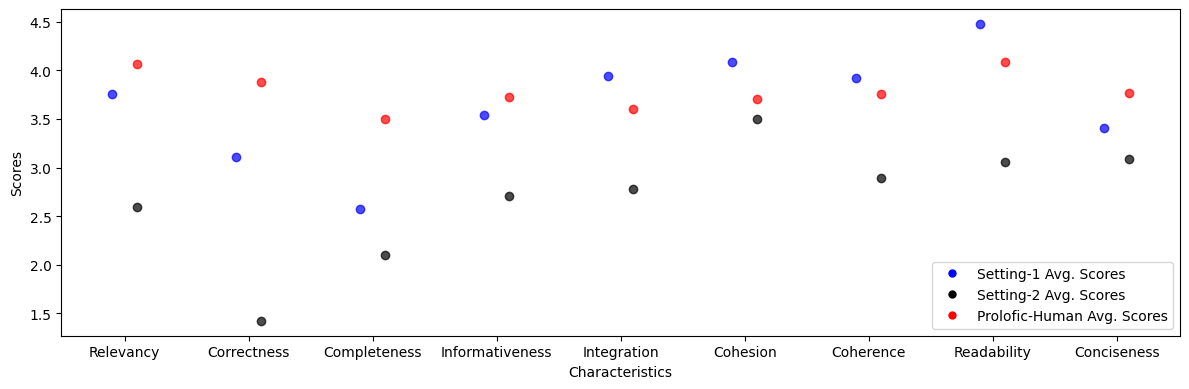

In [4]:
prolofic_dataset_score, prolofic_dataset_reults_dict =  evaluation_report(prolofic_dataset, model='prolofic_dataset', setting='P', fold_prefix='')
print(json.dumps(prolofic_dataset_score, indent=4))

print("-"*50)

vanila = read_json("assets/vanila.json")
vanila_prolific = [item for item in vanila if item['split'] == 'test-prolific']

vanila_prolific_score_s1, vanila_prolific_reults_dict_s1 =  evaluation_report(vanila_prolific, model='vanila', setting='s1', fold_prefix='gpt-4-eval-')
print(json.dumps(vanila_prolific_score_s1, indent=4))

print("-"*50)

vanila_prolific_score_s2, vanila_prolific_reults_dict_s2 =  evaluation_report(vanila_prolific, model='vanila', setting='s2', fold_prefix='gpt-4-eval-')
print(json.dumps(vanila_prolific_score_s2, indent=4))

setting1_scores_vanila_prolific = build_setting_per_fold_matrix(result_list=vanila_prolific, setting='s1', chars=chars, fold_prefix='gpt-4-eval-')
setting2_scores_vanila_prolific = build_setting_per_fold_matrix(result_list=vanila_prolific, setting='s2', chars=chars, fold_prefix='gpt-4-eval-')
prolific_scores_vanila_prolific = build_setting_per_fold_matrix(result_list=prolofic_dataset, setting='P', chars=chars, fold_prefix='')

plot_s1_vs_s2_vs_prolofic(setting1_scores=setting1_scores_vanila_prolific, 
                          setting2_scores=setting2_scores_vanila_prolific, 
                          prolofic_scores=prolific_scores_vanila_prolific, 
                          model='vanila-prolific', chars=chars)

MODEL: prolofic_dataset
SETTING: P
averaged WC>200: 0.4666666666666667
averaged word counts: 199.73333333333332
averaged 150<=WC<=250: 0.4
averaged WC<50: 0.0
averaged 50<=WC<150: 0.36666666666666664
averaged 150<=WC<=220: 0.16666666666666666
averaged 220<=WC<=250: 0.23333333333333334
averaged WC>250: 0.23333333333333334
averaged paper-structure: 0.2
{
    "Relevancy": 4.066666666666667,
    "Correctness": 3.877777777777778,
    "Completeness": 3.4999999999999996,
    "Informativeness": 3.7222222222222223,
    "Integration": 3.5999999999999996,
    "Cohesion": 3.7,
    "Coherence": 3.755555555555555,
    "Readability": 4.088888888888888,
    "Conciseness": 3.766666666666666
}
--------------------------------------------------
MODEL: warmup
SETTING: s1
averaged WC>200: 0.8333333333333334
averaged word counts: 222.1
averaged 150<=WC<=250: 0.9
averaged WC<50: 0.0
averaged 50<=WC<150: 0.0
averaged 150<=WC<=220: 0.5333333333333333
averaged 220<=WC<=250: 0.36666666666666664
averaged WC>250: 

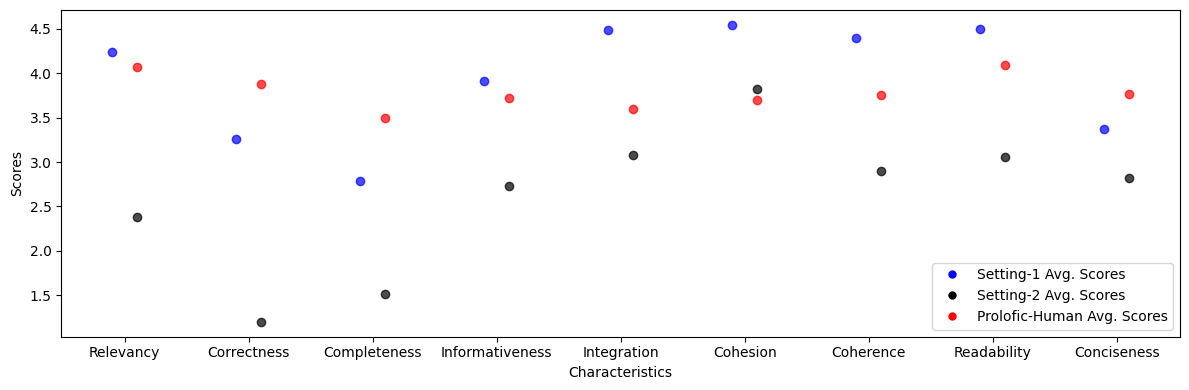

In [5]:
prolofic_dataset_score, prolofic_dataset_reults_dict =  evaluation_report(prolofic_dataset, model='prolofic_dataset', setting='P', fold_prefix='')
print(json.dumps(prolofic_dataset_score, indent=4))

print("-"*50)

warmup = read_json("assets/warmup-inf.json")
warmup_prolific = [item for item in warmup if item['split'] == 'test-prolific']

warmup_prolific_score_s1, warmup_prolific_reults_dict_s1 =  evaluation_report(warmup_prolific, model='warmup', setting='s1', fold_prefix='gpt-4-eval-')
print(json.dumps(warmup_prolific_score_s1, indent=4))

print("-"*50)

warmup_prolific_score_s2, warmup_prolific_reults_dict_s2 =  evaluation_report(warmup_prolific, model='warmup', setting='s2', fold_prefix='gpt-4-eval-')
print(json.dumps(warmup_prolific_score_s2, indent=4))

setting1_scores_warmup_prolific = build_setting_per_fold_matrix(result_list=warmup_prolific, setting='s1', chars=chars, fold_prefix='gpt-4-eval-')
setting2_scores_warmup_prolific = build_setting_per_fold_matrix(result_list=warmup_prolific, setting='s2', chars=chars, fold_prefix='gpt-4-eval-')
prolific_scores_warmup_prolific = build_setting_per_fold_matrix(result_list=prolofic_dataset, setting='P', chars=chars, fold_prefix='')

plot_s1_vs_s2_vs_prolofic(setting1_scores=setting1_scores_warmup_prolific, 
                          setting2_scores=setting2_scores_warmup_prolific, 
                          prolofic_scores=prolific_scores_warmup_prolific, 
                          model='finetuned-prolific', chars=chars)

# Vanila

MODEL: vanila
SETTING: s1
averaged WC>200: 0.5
averaged word counts: 242.22222222222223
averaged 150<=WC<=250: 0.48717948717948717
averaged WC<50: 0.0
averaged 50<=WC<150: 0.17094017094017094
averaged 150<=WC<=220: 0.3888888888888889
averaged 220<=WC<=250: 0.09829059829059829
averaged WC>250: 0.3418803418803419
averaged paper-structure: 0.3247863247863248
{
    "Relevancy": 4.331908831908833,
    "Correctness": 3.663817663817663,
    "Completeness": 3.0099715099715074,
    "Informativeness": 3.945868945868952,
    "Integration": 4.414529914529917,
    "Cohesion": 4.444444444444445,
    "Coherence": 4.3874643874643855,
    "Readability": 4.596866096866097,
    "Conciseness": 3.420227920227922
}
--------------------------------------------------
MODEL: vanila
SETTING: s2
averaged WC>200: 0.5
averaged word counts: 242.22222222222223
averaged 150<=WC<=250: 0.48717948717948717
averaged WC<50: 0.0
averaged 50<=WC<150: 0.17094017094017094
averaged 150<=WC<=220: 0.3888888888888889
averaged 220

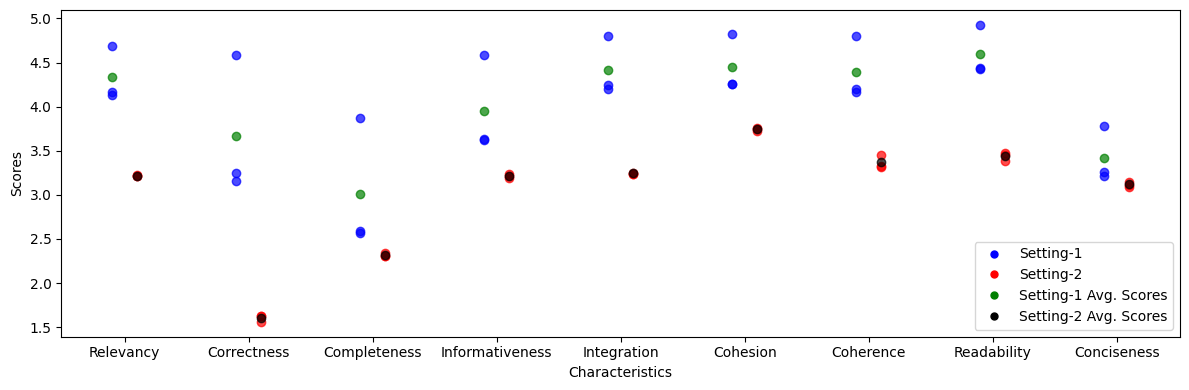

In [6]:
vanila = read_json("assets/vanila.json")
vanila_score_s1, vanila_reults_dict_s1 =  evaluation_report(vanila, model='vanila', setting='s1', fold_prefix='gpt-4-eval-')
print(json.dumps(vanila_score_s1, indent=4))

print("-"*50)

vanila_score_s2, vanila_reults_dict_s2 =  evaluation_report(vanila, model='vanila', setting='s2', fold_prefix='gpt-4-eval-')
print(json.dumps(vanila_score_s2, indent=4))

setting1_scores_vanila = build_setting_per_fold_matrix(result_list=vanila, setting='s1', chars=chars, fold_prefix='gpt-4-eval-')
setting2_scores_vanila = build_setting_per_fold_matrix(result_list=vanila, setting='s2', chars=chars, fold_prefix='gpt-4-eval-')
plot_s1_vs_s2(setting1_scores=setting1_scores_vanila, setting2_scores=setting2_scores_vanila, model='vanila', chars=chars)

# Finetuned

MODEL: warmup
SETTING: s1
averaged WC>200: 0.8333333333333334
averaged word counts: 231.45726495726495
averaged 150<=WC<=250: 0.8162393162393162
averaged WC<50: 0.0
averaged 50<=WC<150: 0.004273504273504274
averaged 150<=WC<=220: 0.47435897435897434
averaged 220<=WC<=250: 0.3547008547008547
averaged WC>250: 0.1794871794871795
averaged paper-structure: 0.01282051282051282
{
    "Relevancy": 4.658119658119659,
    "Correctness": 3.636752136752136,
    "Completeness": 3.132478632478632,
    "Informativeness": 4.217948717948724,
    "Integration": 4.73076923076923,
    "Cohesion": 4.732193732193733,
    "Coherence": 4.690883190883192,
    "Readability": 4.431623931623935,
    "Conciseness": 3.3276353276353285
}
--------------------------------------------------
MODEL: warmup
SETTING: s2
averaged WC>200: 0.8333333333333334
averaged word counts: 231.45726495726495
averaged 150<=WC<=250: 0.8162393162393162
averaged WC<50: 0.0
averaged 50<=WC<150: 0.004273504273504274
averaged 150<=WC<=220: 0.

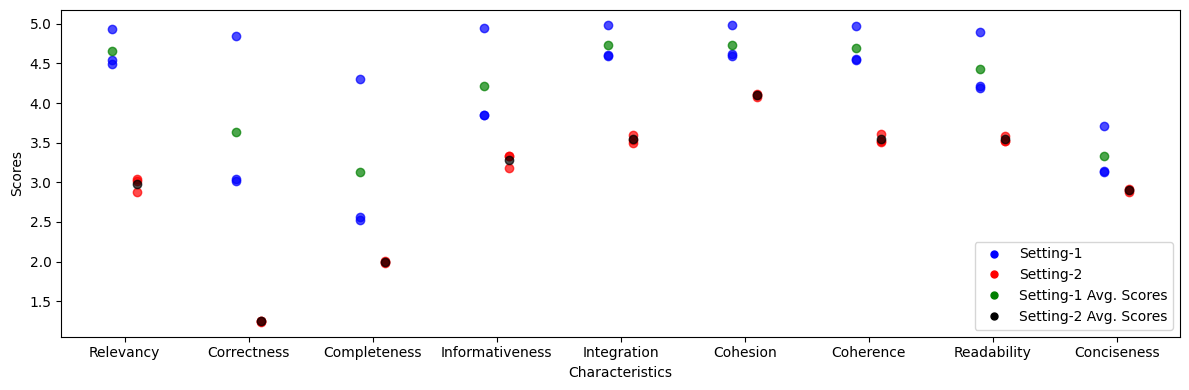

In [7]:
warmup = read_json("assets/warmup-inf.json")
warmup_score_s1, warmup_reults_dict_s1 =  evaluation_report(warmup, model='warmup', setting='s1', fold_prefix='gpt-4-eval-')
print(json.dumps(warmup_score_s1, indent=4))

print("-"*50)

warmup_score_s2, warmup_reults_dict_s2 =  evaluation_report(warmup, model='warmup', setting='s2', fold_prefix='gpt-4-eval-')
print(json.dumps(warmup_score_s2, indent=4))

setting1_scores_warmup = build_setting_per_fold_matrix(result_list=warmup, setting='s1', chars=chars, fold_prefix='gpt-4-eval-')        
setting2_scores_warmup = build_setting_per_fold_matrix(result_list=warmup, setting='s2', chars=chars, fold_prefix='gpt-4-eval-')
plot_s1_vs_s2(setting1_scores=setting1_scores_warmup, setting2_scores=setting2_scores_warmup, model='warmup', chars=chars)

# Finetuned + RLHF

MODEL: finetuned_rlhf
SETTING: s1
averaged WC>200: 0.6324786324786325
averaged word counts: 204.52136752136752
averaged 150<=WC<=250: 0.9871794871794872
averaged WC<50: 0.0
averaged 50<=WC<150: 0.008547008547008548
averaged 150<=WC<=220: 0.8418803418803419
averaged 220<=WC<=250: 0.1581196581196581
averaged WC>250: 0.004273504273504274
averaged paper-structure: 0.0
{
    "Relevancy": 4.484330484330484,
    "Correctness": 3.0968660968660986,
    "Completeness": 2.5598290598290614,
    "Informativeness": 3.841880341880342,
    "Integration": 4.541310541310541,
    "Cohesion": 4.517094017094016,
    "Coherence": 4.477207977207976,
    "Readability": 4.166666666666666,
    "Conciseness": 3.085470085470085
}
--------------------------------------------------
MODEL: finetuned_rlhf
SETTING: s2
averaged WC>200: 0.6324786324786325
averaged word counts: 204.52136752136752
averaged 150<=WC<=250: 0.9871794871794872
averaged WC<50: 0.0
averaged 50<=WC<150: 0.008547008547008548
averaged 150<=WC<=220:

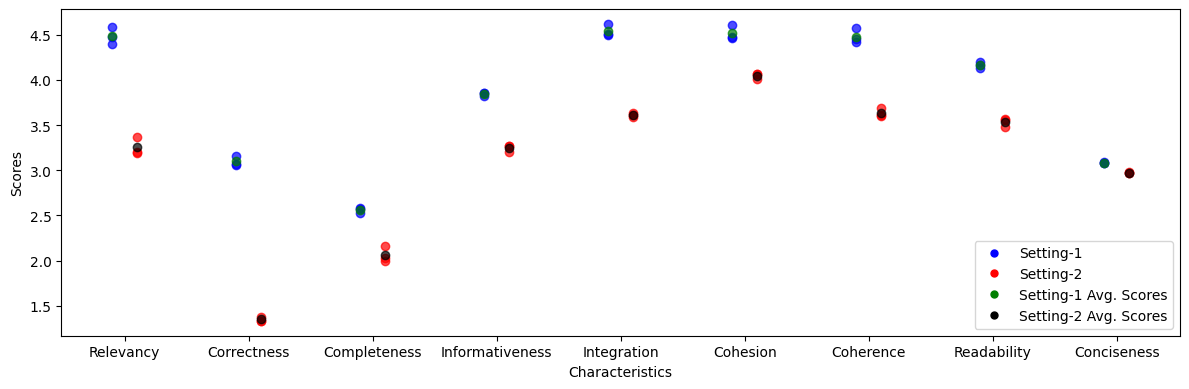

In [8]:
finetuned_rlhf = read_json("assets/rlhf-style-with-warmup-inf.json")
finetuned_rlhf_score_s1, finetuned_rlhf_reults_dict_s1 =  evaluation_report(finetuned_rlhf, model='finetuned_rlhf', setting='s1', fold_prefix='gpt-4-eval-')
print(json.dumps(finetuned_rlhf_score_s1, indent=4))

print("-"*50)

finetuned_rlhf_score_s2, finetuned_rlhf_reults_dict_s2 =  evaluation_report(finetuned_rlhf, model='finetuned_rlhf', setting='s2', fold_prefix='gpt-4-eval-')
print(json.dumps(finetuned_rlhf_score_s2, indent=4))

setting1_scores_finetuned_rlhf = build_setting_per_fold_matrix(result_list=finetuned_rlhf, setting='s1', chars=chars, fold_prefix='gpt-4-eval-')        
setting2_scores_finetuned_rlhf = build_setting_per_fold_matrix(result_list=finetuned_rlhf, setting='s2', chars=chars, fold_prefix='gpt-4-eval-')
plot_s1_vs_s2(setting1_scores=setting1_scores_finetuned_rlhf, setting2_scores=setting2_scores_finetuned_rlhf, model='finetuned_rlhf', chars=chars)

# RLHF

MODEL: rlhf
SETTING: s1
averaged WC>200: 0.5982905982905983
averaged word counts: 189.8760683760684
averaged 150<=WC<=250: 0.8376068376068376
averaged WC<50: 0.0
averaged 50<=WC<150: 0.1581196581196581
averaged 150<=WC<=220: 0.7094017094017094
averaged 220<=WC<=250: 0.1282051282051282
averaged WC>250: 0.004273504273504274
averaged paper-structure: 0.017094017094017096
{
    "Relevancy": 3.9772079772079776,
    "Correctness": 2.9772079772079767,
    "Completeness": 2.267806267806267,
    "Informativeness": 3.411680911680912,
    "Integration": 3.676638176638178,
    "Cohesion": 3.810541310541313,
    "Coherence": 3.76923076923077,
    "Readability": 4.334757834757835,
    "Conciseness": 3.112535612535614
}
--------------------------------------------------
MODEL: rlhf
SETTING: s2
averaged WC>200: 0.5982905982905983
averaged word counts: 189.8760683760684
averaged 150<=WC<=250: 0.8376068376068376
averaged WC<50: 0.0
averaged 50<=WC<150: 0.1581196581196581
averaged 150<=WC<=220: 0.7094017

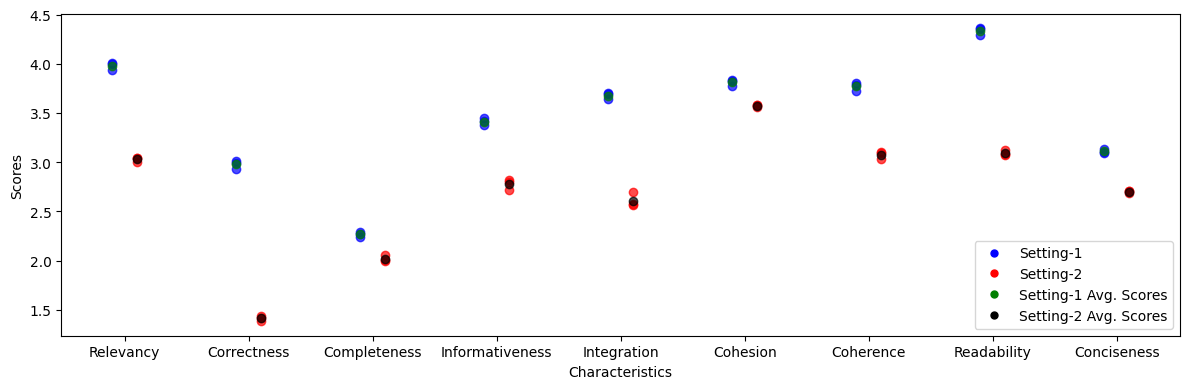

In [9]:
rlhf = read_json('assets/rlhf-style-inf.json')
rlhf_score_s1, rlhf_reults_dict_s1 =  evaluation_report(rlhf, model='rlhf', setting='s1', fold_prefix='gpt-4-eval-')
print(json.dumps(rlhf_score_s1, indent=4))

print("-"*50)

rlhf_score_s2, rlhf_reults_dict_s2 =  evaluation_report(rlhf, model='rlhf', setting='s2', fold_prefix='gpt-4-eval-')
print(json.dumps(rlhf_score_s2, indent=4))

setting1_scores_rlhf = build_setting_per_fold_matrix(result_list=rlhf, setting='s1', chars=chars, fold_prefix='gpt-4-eval-')        
setting2_scores_rlhf = build_setting_per_fold_matrix(result_list=rlhf, setting='s2', chars=chars, fold_prefix='gpt-4-eval-')
plot_s1_vs_s2(setting1_scores=setting1_scores_rlhf, setting2_scores=setting2_scores_rlhf, model='rlhf', chars=chars)

# Finetuned + RLHF (GPT4-Features)

MODEL: finetuned_rlhf_gpt4
SETTING: s1
averaged WC>200: 0.6581196581196581
averaged word counts: 205.9059829059829
averaged 150<=WC<=250: 1.0
averaged WC<50: 0.0
averaged 50<=WC<150: 0.0
averaged 150<=WC<=220: 0.8675213675213675
averaged 220<=WC<=250: 0.14957264957264957
averaged WC>250: 0.0
averaged paper-structure: 0.0
{
    "Relevancy": 4.880341880341879,
    "Correctness": 4.757834757834757,
    "Completeness": 4.1937321937321945,
    "Informativeness": 4.834757834757832,
    "Integration": 4.89031339031339,
    "Cohesion": 4.890313390313389,
    "Coherence": 4.858974358974357,
    "Readability": 4.784900284900283,
    "Conciseness": 3.649572649572651
}
--------------------------------------------------
MODEL: finetuned_rlhf_gpt4
SETTING: s2
averaged WC>200: 0.6581196581196581
averaged word counts: 205.9059829059829
averaged 150<=WC<=250: 1.0
averaged WC<50: 0.0
averaged 50<=WC<150: 0.0
averaged 150<=WC<=220: 0.8675213675213675
averaged 220<=WC<=250: 0.14957264957264957
averaged WC

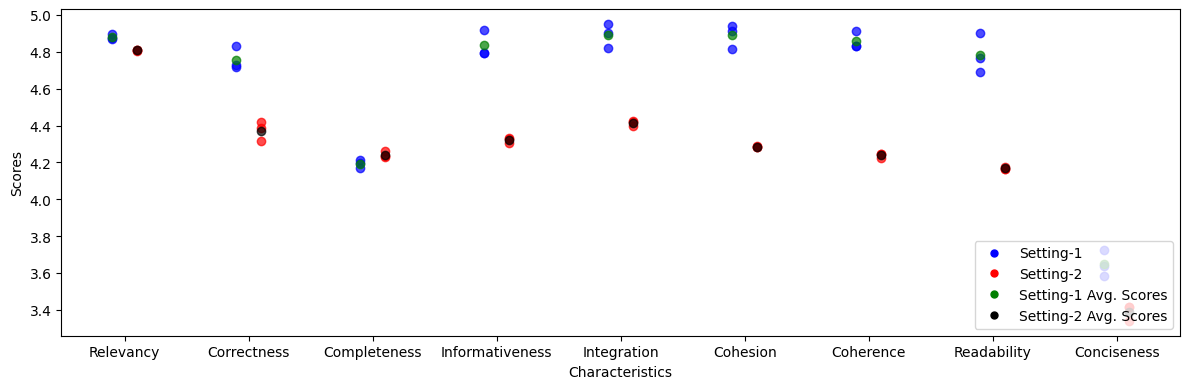

In [10]:
rlhf = read_json('assets/rlhf-style-gpt4-with-warmup-inf.json')
rlhf_score_s1, rlhf_reults_dict_s1 =  evaluation_report(rlhf, model='finetuned_rlhf_gpt4', setting='s1', fold_prefix='gpt-4-eval-')
print(json.dumps(rlhf_score_s1, indent=4))

print("-"*50)

rlhf_score_s2, rlhf_reults_dict_s2 =  evaluation_report(rlhf, model='finetuned_rlhf_gpt4', setting='s2', fold_prefix='gpt-4-eval-')
print(json.dumps(rlhf_score_s2, indent=4))

setting1_scores_rlhf = build_setting_per_fold_matrix(result_list=rlhf, setting='s1', chars=chars, fold_prefix='gpt-4-eval-')        
setting2_scores_rlhf = build_setting_per_fold_matrix(result_list=rlhf, setting='s2', chars=chars, fold_prefix='gpt-4-eval-')
plot_s1_vs_s2(setting1_scores=setting1_scores_rlhf, setting2_scores=setting2_scores_rlhf, model='finetuned_rlhf_gpt4', chars=chars)

# RLHF (GPT4-Features)

In [11]:
rlhf = read_json('assets/rlhf-style-gpt4-inf.json')
rlhf_score_s1, rlhf_reults_dict_s1 =  evaluation_report(rlhf, model='rlhf_gpt4', setting='s1', fold_prefix='gpt-4-eval-')
print(json.dumps(rlhf_score_s1, indent=4))

print("-"*50)

# rlhf_score_s2, rlhf_reults_dict_s2 =  evaluation_report(rlhf, model='rlhf_gpt4', setting='s2', fold_prefix='gpt-4-eval-')
# print(json.dumps(rlhf_score_s2, indent=4))

# setting1_scores_rlhf = build_setting_per_fold_matrix(result_list=rlhf, setting='s1', chars=chars, fold_prefix='gpt-4-eval-')        
# setting2_scores_rlhf = build_setting_per_fold_matrix(result_list=rlhf, setting='s2', chars=chars, fold_prefix='gpt-4-eval-')
# plot_s1_vs_s2(setting1_scores=setting1_scores_rlhf, setting2_scores=setting2_scores_rlhf, model='rlhf_gpt4', chars=chars)

MODEL: rlhf_gpt4
SETTING: s1
averaged WC>200: 0.6452991452991453
averaged word counts: 194.0982905982906
averaged 150<=WC<=250: 0.8717948717948718
averaged WC<50: 0.004273504273504274
averaged 50<=WC<150: 0.11965811965811966
averaged 150<=WC<=220: 0.7606837606837606
averaged 220<=WC<=250: 0.11965811965811966
averaged WC>250: 0.004273504273504274
averaged paper-structure: 0.008547008547008548
{
    "Relevancy": 4.754985754985755,
    "Correctness": 4.3917378917378915,
    "Completeness": 3.5484330484330493,
    "Informativeness": 4.286324786324786,
    "Integration": 4.7407407407407405,
    "Cohesion": 4.780626780626781,
    "Coherence": 4.737891737891737,
    "Readability": 4.901709401709403,
    "Conciseness": 3.65954415954416
}
--------------------------------------------------


# GPT-4 Vanilla

In [9]:
result_list = read_json('assets/gpt4-vanilla.json')
rlhf_score_s1, rlhf_reults_dict_s1 =  evaluation_report(result_list, model='gpt4_vanila', setting='s1', fold_prefix='gpt-4-eval-')
print(json.dumps(rlhf_score_s1, indent=4))

MODEL: gpt4_vanila
SETTING: s1
averaged WC>200: 0.8247863247863247
averaged word counts: 218.32051282051282
averaged 150<=WC<=250: 0.9102564102564102
averaged WC<50: 0.0
averaged 50<=WC<150: 0.0
averaged 150<=WC<=220: 0.6153846153846154
averaged 220<=WC<=250: 0.32051282051282054
averaged WC>250: 0.08974358974358974
averaged paper-structure: 0.01282051282051282
{
    "Relevancy": 4.9743589743589745,
    "Correctness": 4.937321937321937,
    "Completeness": 4.427350427350428,
    "Informativeness": 4.957264957264957,
    "Integration": 4.9914529914529915,
    "Cohesion": 4.9914529914529915,
    "Coherence": 4.981481481481482,
    "Readability": 4.964387464387464,
    "Conciseness": 3.894586894586894
}


In [20]:
import tracemalloc
tracemalloc.start()

# Your code here
my_list = [1, 2, 3, 4, 5]

snapshot = tracemalloc.take_snapshot()
top_stats = snapshot.statistics('lineno')

print("Top 10 lines")
for stat in top_stats[:10]:
    print(stat)


Top 10 lines
/opt/conda/envs/python3/lib/python3.9/codeop.py:143: size=221 B, count=2, average=110 B
/opt/conda/envs/python3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3400: size=120 B, count=1, average=120 B
/opt/conda/envs/python3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3390: size=96 B, count=3, average=32 B
/tmp/ipykernel_3404738/1983118417.py:5: size=64 B, count=1, average=64 B
/opt/conda/envs/python3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3449: size=64 B, count=1, average=64 B
/opt/conda/envs/python3/lib/python3.9/site-packages/IPython/core/compilerop.py:192: size=28 B, count=1, average=28 B


In [ ]:
print(f"Memory usage: {process.memory_info().rss} bytes")

In [15]:
import os
print(f"Current PID: {os.getpid()}")

Current PID: 3404738


In [18]:
os.getpid("ls")

TypeError: posix.getpid() takes no arguments (1 given)